In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ECE ENGR 219/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECE ENGR 219


In [2]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import tensorflow as tf
import re
import math
import matplotlib.pyplot as plt
import datetime
import pytz
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#GET STATS DATA
def get_tweets(hashtag):
  tweets_stats = []
  with open('/content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/tweets_' + hashtag +'.txt') as file:
    for line in file:
      obj = json.loads(line)
      tweets_stats.append([obj['citation_date'], obj['author']['followers'], obj['metrics']['citations']['total']])
  return tweets_stats
tweets_stats = {}
hashtag_list = ['#gopatriots', '#gohawks', '#patriots', '#nfl', '#sb49', '#superbowl']
for hashtag in hashtag_list:
  tweets_stats[hashtag] = get_tweets(hashtag)

#Question 9.1

In [ ]:
for hashtag in hashtag_list:
  #Average number of tweets per hour
  hours = [tweet[1] for tweet in tweets_stats[hashtag]]
  print(hashtag, 'average number of tweets per hour:', len(tweets_stats[hashtag])/((max(hours)-min(hours))/3600.))
  #Average number of followers of users posting the tweets per tweet
  total_fol = sum([tweet[1] for tweet in tweets_stats[hashtag]])
  print(hashtag, 'average number of followers of users posting the tweets per tweet:', total_fol/len(tweets_stats[hashtag]))
  #Average number of retweets per tweet
  total_fol = sum([tweet[2] for tweet in tweets_stats[hashtag]])
  print(hashtag, 'average number of retweets per tweet:', total_fol/len(tweets_stats[hashtag]))
  print()

#gopatriots average number of tweets per hour: 27.507083985075123
#gopatriots average number of followers of users posting the tweets per tweet: 1427.2526051635405
#gopatriots average number of retweets per tweet: 1.4081919101697078

#gohawks average number of tweets per hour: 128.9393704190874
#gohawks average number of followers of users posting the tweets per tweet: 2217.9237355281984
#gohawks average number of retweets per tweet: 2.0132093991319877

#patriots average number of tweets per hour: 163.91593002428715
#patriots average number of followers of users posting the tweets per tweet: 3280.4635616550277
#patriots average number of retweets per tweet: 1.7852871288476946

#nfl average number of tweets per hour: 87.16640540688259
#nfl average number of followers of users posting the tweets per tweet: 4662.37544523693
#nfl average number of retweets per tweet: 1.5344602655543254

#sb49 average number of tweets per hour: 40.93186763024069
#sb49 average number of followers of users po

#Question 9.2

In [ ]:
def report_tweets(filename):
    with open(filename, 'r') as file:
        t_max = 0
        t_min = np.inf
        lines = file.readlines()
        for line in lines:
            json_obj = json.loads(line)
            t_max = max(t_max, json_obj['citation_date'])
            t_min = min(t_min, json_obj['citation_date'])
        all_hours = math.ceil((t_max - t_min) / 3600)
        n_tweets = [0] * all_hours
        for line in lines:
            json_obj = json.loads(line)
            index = math.floor((json_obj['citation_date'] - t_min) / 3600)
            n_tweets[index] += 1
        return n_tweets

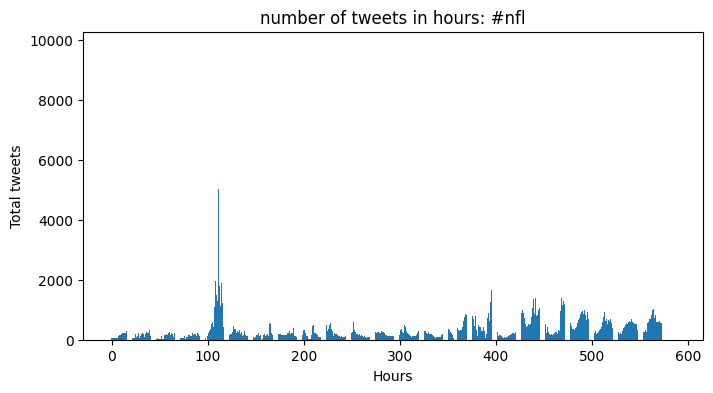

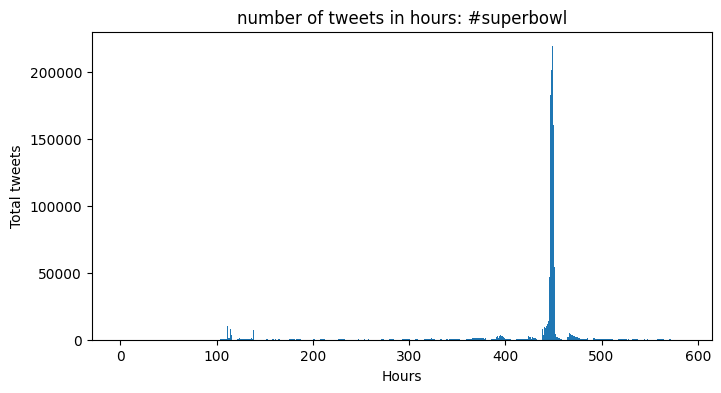

In [ ]:
hashtags = ['#nfl','#superbowl']

for hashtag in hashtags:
    all_tweets = report_tweets('/content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/tweets_'+hashtag+'.txt')
    plt.figure(figsize=(8,4))
    plt.bar(range(len(all_tweets)),all_tweets)
    plt.xlabel('Hours')
    plt.ylabel('Total tweets')
    plt.title('number of tweets in hours: '+hashtag)

#Question 10

**Describe Task**: I chose to create 3 different models for 3 different tasks. The first involved predicting the one out of the 10 most used hashtags for a given tweet. At first I wanted to predict multiple of the top 10 hashtags, but after doing some data exploration I realized that a majority of the tweets only contained one of the top 10 tweets. So then I decided to do a multi class classification task using fastText as the model to make predictions. The second task I worked on was a binary classification task that used the data solely from the patriots and hawks tweets dataset to predict which team the user tweeting it supported. Again, here I used fastText to do the prediction. In the last task, I used a tokenizer to get the embeddings of the tweets and passed it through a neural network to predict the number of retweets a user could have gotten, given a tweet.

**Describe Feature Engineering Process:**
-  Subsampled with goptatriots tweet text because that dataset had the least amount of data out of all txt files
    - Graphed frequency of all the tweet data
- Created a heat map with correlations between all the numerical features
    - When training the neural network, chose to use the feature most correlated with number of retweets(momentum with a correlation of 0.55) which ended up reducing the rise by a lot
    - Didnt put other numerical features which had less than 0.5 for correlation
- When using fast text, I would have added more textual features, but fastText was pretty good at predicting without any additional information other than tweet
- I also removed hashtags for the tasks necessary because didn’t want model to ‘cheat’

In [3]:
%cd ECE219_tweet_data/fastText-0.9.2
!make
!pip install .

/content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/fastText-0.9.2
make: Nothing to be done for 'opt'.
Processing /content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/fastText-0.9.2
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199782 sha256=d5adc5ea6ad79489c8dae992fd6baca8f55802485b36b1c1ac36977acec05219
  Stored in directory: /root/.cache/pip/wheels/1f/e3/48/c142b860724c501aa9d814ec942e58aea80cd6b352839f1d05
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


In [4]:
#GET ALL DATA
hashtag_tracker = defaultdict(int)
tweets_data = []
hashtag_list = ['#gopatriots', '#gohawks', '#patriots', '#nfl', '#sb49', '#superbowl']
for hashtag in hashtag_list:
  with open('/content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/tweets_' + hashtag +'.txt') as file:
    for line in file:
      obj = json.loads(line)
      stats = {}
      stats['hashtag'] = hashtag
      stats['tweet'] = obj['tweet']['text']
      stats['display_name'] = obj['original_author']['name']
      stats['handle'] = obj['original_author']['nick']
      stats['citation_date'] = obj['citation_date']
      stats['firstpost_date'] = obj['firstpost_date']
      stats['follower_count'] = obj['author']['followers']
      stats['retweets'] = obj['metrics']['citations']['total']
      stats['ranking_score'] = obj['metrics']['ranking_score']
      stats['peak'] = obj['metrics']['peak']
      stats['impressions'] = obj['metrics']['impressions']
      stats['momentum'] = obj['metrics']['momentum']
      list_hashtags = []
      for h in obj['tweet']['entities']['hashtags']:
        list_hashtags.append(h['text'])
        hashtag_tracker[h['text']] += 1
      stats['list_hashtag'] = list_hashtags
      tweets_data.append(stats)

In [5]:
df_tweets = pd.DataFrame(tweets_data)
len_pat = len(df_tweets[df_tweets['hashtag'] == '#gopatriots'])
df_hawks = df_tweets[df_tweets['hashtag'] == '#gohawks'][:(len_pat + 1)]
df_nfl = df_tweets[df_tweets['hashtag'] == '#gonfl'][:(len_pat + 1)]
df_pat = df_tweets[df_tweets['hashtag'] == '#patriots'][:(len_pat + 1)]
df_sb = df_tweets[df_tweets['hashtag'] == '#sb49'][:(len_pat + 1)]
df_superbowl = df_tweets[df_tweets['hashtag'] == '#superbowl'][:(len_pat + 1)]
df_short = df_tweets[(df_tweets['hashtag'] == '#gopatriots')].append([df_hawks, df_nfl, df_pat, df_sb, df_superbowl])

<ipython-input-5-fbcb0fddebef>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_short = df_tweets[(df_tweets['hashtag'] == '#gopatriots')].append([df_hawks, df_nfl, df_pat, df_sb, df_superbowl])


**Explore Data**

<ipython-input-19-b15afff02c4b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrM = df_short.corr()


Text(0.5, 1.0, 'Correlation Between Variables')

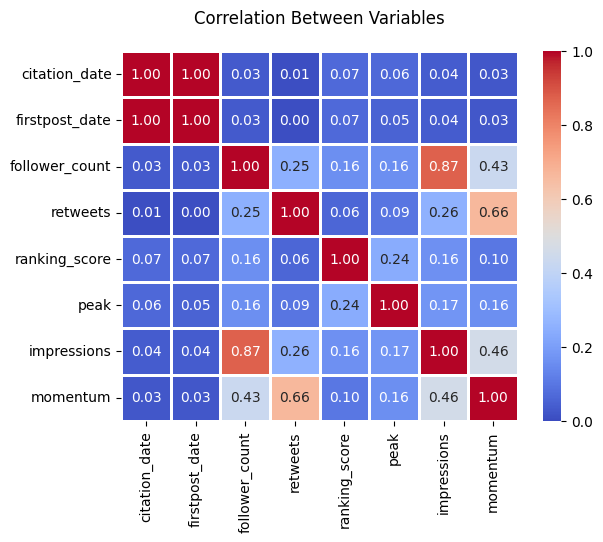

In [19]:
corrM = df_short.corr()
corr = corrM.abs()
sns.heatmap(corr, vmin=0, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=2)
plt.title("Correlation Between Variables", pad=20)

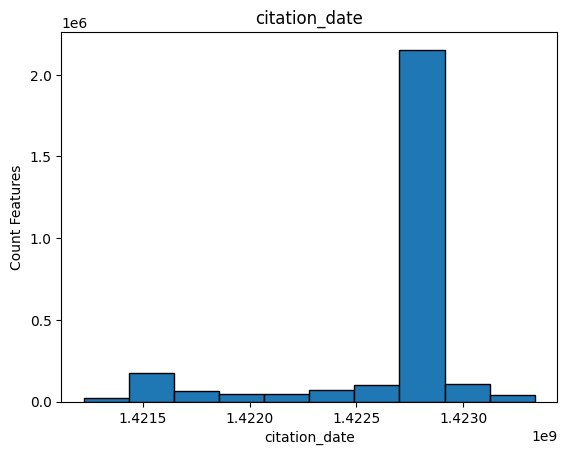

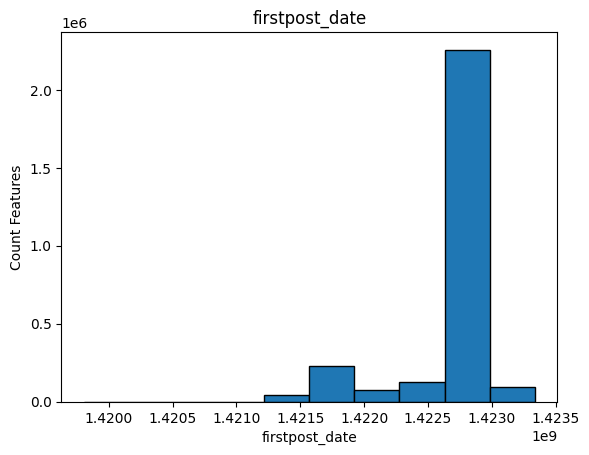

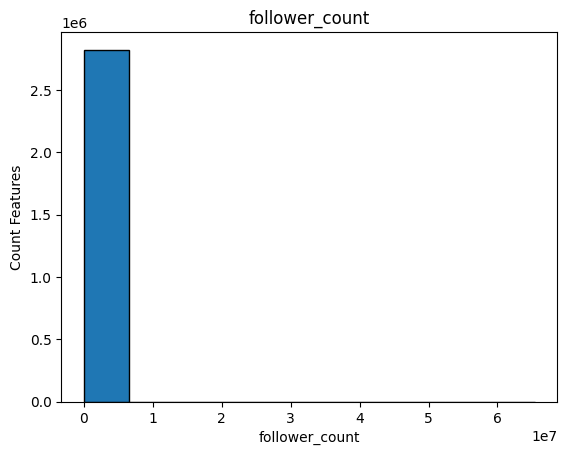

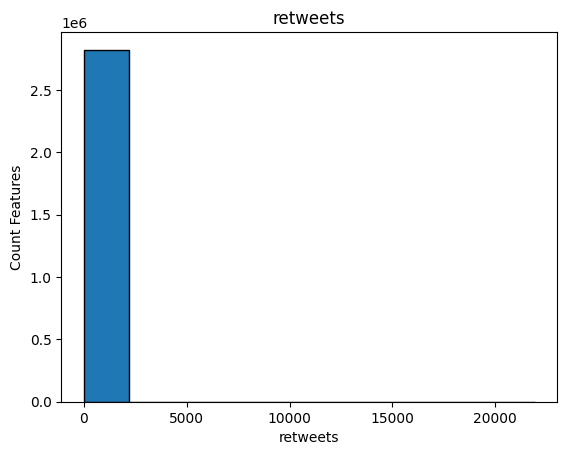

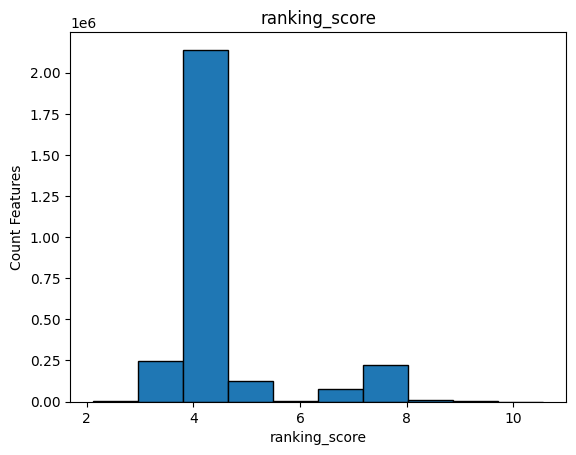

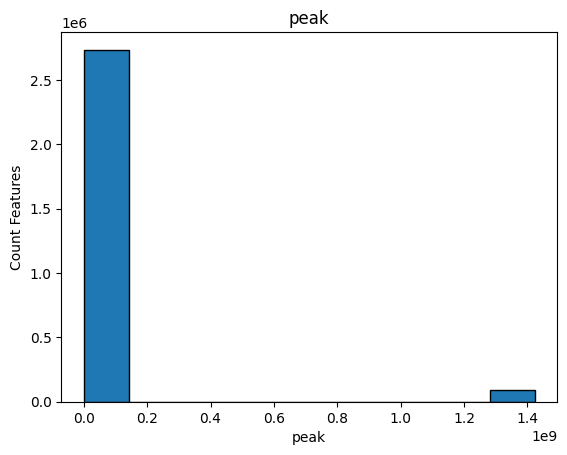

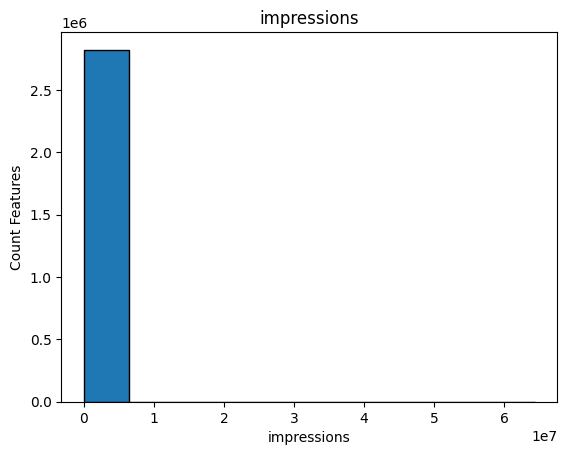

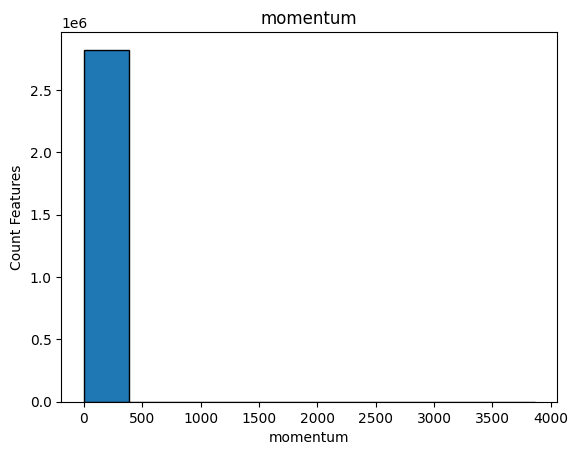

In [20]:
num_features = ['citation_date', 'firstpost_date', 'follower_count', 'retweets', 'ranking_score', 'peak', 'impressions', 'momentum']

for i in np.arange(len(num_features)) :
  plt.figure()
  plt.hist(df_tweets[num_features[i]], edgecolor = "black")
  plt.xlabel(f"{num_features[i]}");
  plt.ylabel("Count Features");
  plt.title(f"{num_features[i]}")

Text(0.5, 1.0, 'momentum')

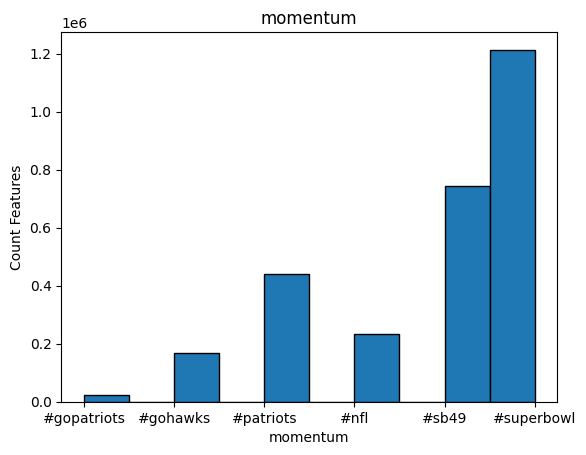

In [21]:
plt.figure()
plt.hist(df_tweets['hashtag'], edgecolor = "black")
plt.xlabel(f"{num_features[i]}");
plt.ylabel("Count Features");
plt.title(f"{num_features[i]}")

In [ ]:
sorted(hashtag_tracker, key=hashtag_tracker.get, reverse=True)[:10]

['SB49',
 'SuperBowl',
 'SuperBowlXLIX',
 'PatriotsWIN',
 'Patriots',
 'NFL',
 'SeahawksWIN',
 'GoHawks',
 'Seahawks',
 'superbowl']

**Predict Hashtag**

In [ ]:
hashtag_classes = sorted(hashtag_tracker, key=hashtag_tracker.get, reverse=True)[:10]

In [ ]:
df_hashtag = pd.DataFrame(columns=['tweet', 'top_hashtag'])

In [ ]:
count_hashtags = {}
for h in hashtag_classes:
  count_hashtags[h] = 10000

In [ ]:
i = 0
for index, row in df_short.iterrows():
  check = False
  check2 = True
  for h in row['list_hashtag']:
    tmp = []
    if h in count_hashtags and count_hashtags[h] > 0:
      count_hashtags[h] -= 1
      tmp.append(h)
      check = True
  if len(tmp) > 0:
    df_hashtag.loc[i] = [row['tweet'], tmp[0]]
    i += 1
  for key in count_hashtags:
    if count_hashtags[key] > 0:
      check2 = False
  if check2:
    break

Step to removes the hashtags

In [ ]:
df_hashtag['tweet'] = df_hashtag['tweet'].apply(lambda x: re.sub("@[A-Za-z0-9_]+","", x))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_hashtag['tweet'],df_hashtag['top_hashtag'],test_size=0.2, shuffle=True)

In [ ]:
with open('/content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/hashtag_train_data.txt', 'w') as writefile:
  for i in range(len(X_train)):
    writefile.write("__label__"+y_train.iloc[i]+" "+X_train.iloc[i].replace("\n"," ")+"\n")

In [ ]:
import fasttext
model_hashtag = fasttext.train_supervised(input="/content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/hashtag_train_data.txt", lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')

In [ ]:
preds = []
for i in range(len(X_test)):
  preds.append(model_hashtag.predict(X_test.iloc[i].replace("\n"," "))[0][0][9:])

Precision, Recall, Fscores, Support(in theat order) for each hashtag in the lists below

In [ ]:
precision_recall_fscore_support(y_test, preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.9742268 , 0.94295302, 0.95721925, 1.        , 0.95813953,
        0.92631579, 0.        , 0.97364341, 0.98029557, 0.98165138]),
 array([0.98878924, 0.93979933, 0.97707424, 0.625     , 0.96827262,
        0.81230769, 0.        , 0.96615385, 0.97358121, 0.97272727]),
 array([0.98145401, 0.94137353, 0.96704484, 0.76923077, 0.96317943,
        0.86557377, 0.        , 0.96988417, 0.97692685, 0.97716895]),
 array([1338,  299,  916,   16,  851,  325,    0,  650, 1022,  110]))

Accuracy Score: 0.9638140039804596

In [ ]:
accuracy_score(y_test, preds)

0.9638140039804596

**Predict Team**

In [ ]:
len_pat = len(df_tweets[df_tweets['hashtag'] == '#gopatriots'])
df_hawks = df_tweets[df_tweets['hashtag'] == '#gohawks'][:(len_pat + 1)]
df_teams = df_tweets[(df_tweets['hashtag'] == '#gopatriots')].append(df_hawks)

<ipython-input-104-29ceecf5815a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_teams = df_tweets[(df_tweets['hashtag'] == '#gopatriots')].append(df_hawks)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_teams['tweet'],df_teams['hashtag'],test_size=0.2, shuffle=True)

In [ ]:
with open('/content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/team_train_data.txt', 'w') as writefile:
  for i in range(len(X_train)):
    writefile.write("__label__"+y_train.iloc[i]+" "+X_train.iloc[i].replace("\n"," ")+"\n")

In [ ]:
import fasttext
model = fasttext.train_supervised(input="/content/drive/MyDrive/ECE ENGR 219/ECE219_tweet_data/team_train_data.txt", lr=1.0, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='hs')

In [ ]:
preds = []
for i in range(len(X_test)):
  preds.append(model.predict(X_test.iloc[i].replace("\n"," "))[0][0][9:])

Precision, Recall, Fscores, Support(in theat order) for each team in the lists below

In [ ]:
precision_recall_fscore_support(y_test, preds)

(array([0.99611231, 0.99518325]),
 array([0.99503776, 0.99622642]),
 array([0.99557474, 0.99570456]),
 array([4635, 4770]))

Accuracy Score: 0.9956406166932483

In [ ]:
accuracy_score(y_test, preds)

0.9956406166932483

**Predict Retweets**

In [14]:
X_train,X_test,y_train,y_test = train_test_split(df_short[['tweet', 'momentum']], df_short['retweets'],test_size=0.2, shuffle=True)
tweet_data = X_train['tweet']
targets = y_train

In [15]:
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tweet_data)
sequences = tokenizer.texts_to_sequences(tweet_data)

In [16]:
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [9]:
tmp_padded_sequences = np.insert(padded_sequences, 33, X_train['momentum'], axis=1)

In [10]:
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
    Dense(64, activation='relu', input_shape=(34,)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(tmp_padded_sequences, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
1323/1323 [==============================] - 5s 3ms/step - loss: 2870.9443 - val_loss: 259.7613
Epoch 2/10
1323/1323 [==============================] - 4s 3ms/step - loss: 2593.2625 - val_loss: 259.1746
Epoch 3/10
1323/1323 [==============================] - 4s 3ms/step - loss: 2589.3987 - val_loss: 259.1754
Epoch 4/10
1323/1323 [==============================] - 3s 2ms/step - loss: 2580.9280 - val_loss: 259.4706
Epoch 5/10
1323/1323 [==============================] - 3s 2ms/step - loss: 2557.8718 - val_loss: 259.1740
Epoch 6/10
1323/1323 [==============================] - 4s 3ms/step - loss: 2555.9016 - val_loss: 258.1605
Epoch 7/10
1323/1323 [==============================] - 4s 3ms/step - loss: 2416.3438 - val_loss: 256.3393
Epoch 8/10
1323/1323 [==============================] - 3s 2ms/step - loss: 2202.2822 - val_loss: 256.9002
Epoch 9/10
1323/1323 [==============================] - 3s 2ms/step - loss: 2024.6555 - val_loss: 255.0045
Epoch 10/10
1323/1323 [==============

MSE training with momentum feature: 172.7850799560547

In [18]:
sequences_test = tokenizer.texts_to_sequences(X_test['tweet'])
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length)
tmp_padded_sequences_test = np.insert(padded_sequences_test, max_sequence_length, X_test['momentum'], axis=1)
# Evaluate the model
loss = model.evaluate(tmp_padded_sequences_test, y_test)
print("Test Loss:", loss)

735/735 [==============================] - 3s 3ms/step - loss: 172.7851
Test Loss: 172.7850799560547


MSE prior to training with momentum feature: 271.0411682128906

In [ ]:
tokenizer.fit_on_texts(X_test['tweet'])
sequences = tokenizer.texts_to_sequences(X_test['tweet'])
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
# Evaluate the model
loss = model.evaluate(padded_sequences, y_test)
print("Test Loss:", loss)

735/735 [==============================] - 4s 5ms/step - loss: 271.0412
Test Loss: 271.0411682128906
